In [ ]:
"""
1. Importing necessary libraries:

- `matplotlib.pyplot`: For plotting graphs.
- `numpy`: For numerical calculations.
- `pandas`: For data manipulation.
- `seaborn`: For data visualization.
- `cv2`: For reading and resizing the images.
- `tensorflow`: A machine learning framework for defining and training the model.
- `ImageDataGenerator`: For data augmentation in Keras.
- `tqdm`: For displaying a progress bar.
- `os`: For reading file and directory structure.
- `shuffle`: To shuffle the data.
- `train_test_split`: To split the dataset into the training set and test set.
- `EfficientNetB0`: Pretrained model used for transfer learning.
- `EarlyStopping`, `ReduceLROnPlateau`, `TensorBoard`, `ModelCheckpoint`: Various callbacks for Keras.
- `classification_report`, `confusion_matrix`: For model evaluation.

2. Defining the labels of the classes. These are 'glioma_tumor', 'no_tumor', 'meningioma_tumor', and 'pituitary_tumor'.

3. Loading and preprocessing the data:

- The images are read from their directories using `cv2.imread()`.
- They are then resized to (150,150) using `cv2.resize()`.
- The processed images are appended to `X_train` and their labels to `y_train`.

4. The data is shuffled and split into training and test sets using `shuffle` and `train_test_split`.

5. The labels are converted to one-hot vectors for model training.

6. The base model `EfficientNetB0` is initialized with pre-trained ImageNet weights.

7. Custom layers are added on top of the base model:

- `GlobalAveragePooling2D`: This layer is used to reduce the spatial dimensions of the output volume.
- `Dropout`: This is a regularization method where input units are dropped with a given probability to prevent overfitting.
- `Dense`: This is the output layer with 4 units (one for each class) and 'softmax' activation.

8. The model is compiled with the 'categorical_crossentropy' loss function, 'Adam' optimizer and 'accuracy' as the evaluation metric.

9. Callbacks are set up:

- `TensorBoard`: For visualization of model training.
- `ModelCheckpoint`: To save the model weights after every epoch.
- `ReduceLROnPlateau`: To reduce learning rate when a metric has stopped improving.

10. The model is trained using the `fit` function.

11. Predictions are made on the test set and the model is evaluated using `classification_report`.

12. A confusion matrix is plotted for a more detailed analysis of the model's performance.
"""

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from warnings import filterwarnings
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [ ]:
#The link of the data we use in this project: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

In [9]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [10]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('brain_tumor_data','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('brain_tumor_data','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 311.10it/s]


In [11]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [12]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [13]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [14]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model) #Maxpooling'de filtrenin içindeki max değeri alıyorduk, bunda ise filtrenin içindeki değerlerin ortalamasını alıyoruz. Böylece daha genel bir sonuç alıyoruz.
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [15]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['Accuracy'])

In [16]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnetforbraintumor.h5",monitor="val_accuracy",save_best_only=True,mode = "auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.3,patience=2,min_delta=0.001,
                              mode = 'auto',verbose=1)

In [17]:
hist = model.fit(X_train,y_train,validation_split=0.1,epochs = 12, verbose=1 , batch_size=32,
                 callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - 97s 1s/step - loss: 0.4514 - Accuracy: 0.8358 - val_loss: 0.3889 - val_Accuracy: 0.8741 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - 84s 1s/step - loss: 0.1841 - Accuracy: 0.9364 - val_loss: 0.1507 - val_Accuracy: 0.9456 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - 81s 975ms/step - loss: 0.1303 - Accuracy: 0.9576 - val_loss: 0.2505 - val_Accuracy: 0.9286 - lr: 0.0010
Epoch 4/12
83/83 [==============================] - 83s 996ms/step - loss: 0.1062 - Accuracy: 0.9671 - val_loss: 0.1481 - val_Accuracy: 0.9524 - lr: 0.0010
Epoch 5/12
83/83 [==============================] - 93s 1s/step - loss: 0.0687 - Accuracy: 0.9788 - val_loss: 0.3983 - val_Accuracy: 0.9014 - lr: 0.0010
Epoch 6/12
83/83 [==============================] - 94s 1s/step - loss: 0.0548 - Accuracy: 0.9841 - val_loss: 0.1749 - val_Accuracy: 0.9524 - lr: 0.0010
Epoch 7/12
83/83 [==============================] - 89s 1s/step - loss: 0.06

In [23]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 3s 213ms/step


In [27]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95        93
           1       0.98      0.96      0.97        51
           2       0.93      0.96      0.94        96
           3       0.97      0.99      0.98        87

    accuracy                           0.96       327
   macro avg       0.96      0.96      0.96       327
weighted avg       0.96      0.96      0.96       327



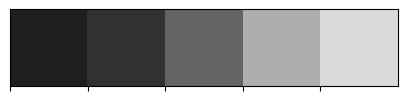

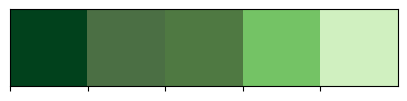

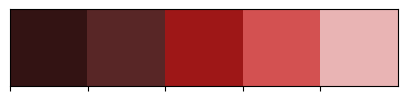

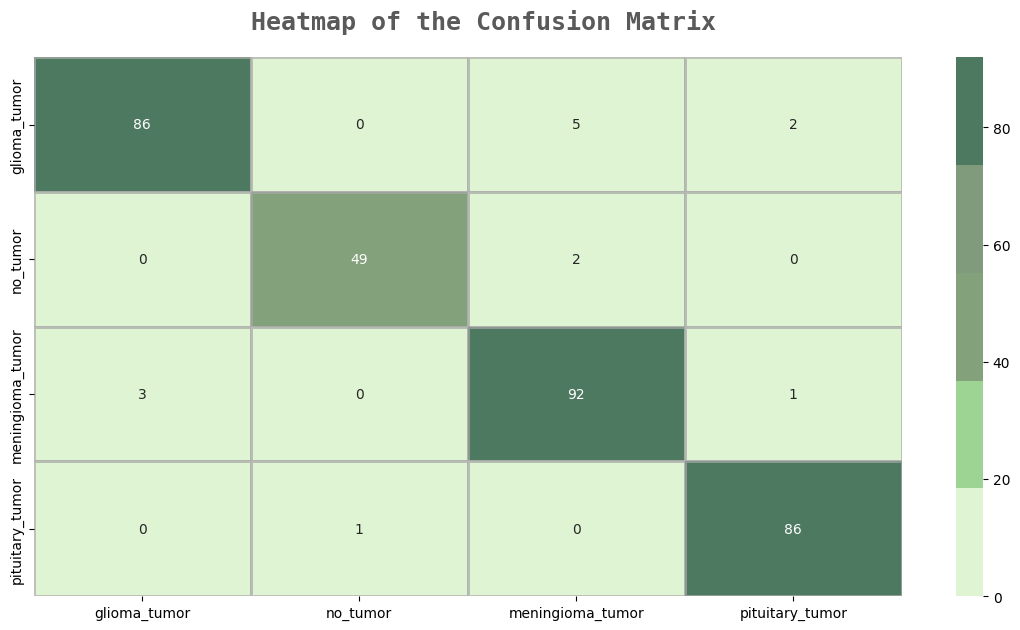

In [29]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()